# Environment Setup

In [1]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from IPython import get_ipython
def is_using_colab() -> bool:
    """Returns whether if running on the Colab platform."""
    return "google.colab" in str(get_ipython())

In [2]:
PARAMS = {
    # It can be "gpu" or "cpu"
    "DEVICE": "gpu",
    # Where the lightning_logs folder will be stored to save experiments
    "EXPERIMENTS_DIR" : "../05 - Experiments",

    # Base path where datasets are contained
    "BASE_DATASETS_PATH" : r"C:\datasets",
    "DATASET_NAME": "DIV2K_5_FIX",
    
    "DATASET_PARAMS" : {
        "limit": None,
        "preload_to_RAM": True,
        "crop_size": (128, 128),
        "events_normalization": None,
        "convert_to_bw": False
    },

    "DATALOADER_PARAMS" : {
        "batch_size": 16,
        "num_workers": 0,
        "pin_memory": True,
    },

    "MODEL": {
        "class_name": "StudentI",
        "teacher": "Teacher",
        "teacher_path": "teacher-epoch=287-step=18144.ckpt",
        "MODEL_PARAMS" : {
            "patch_size": (32, 32),
            "output_size": (128, 8, 8),
            "encoder_dim": 128,
            "decoder_dim": 128,
            "heads": 1,
            "num_layers": 1,
            "lr": 1e-4,
            "features_weight": 1 / 60,
            "images_weight": 1
        },
    },
    "TRAINING_PARAMS": {
        "n_epochs": 100,
        "comment": "StudentI - e-128 d-128 1h 1l"
    }
}

if is_using_colab():
    # Override default options
    PARAMS["DEVICE"] = "gpu"
    PARAMS["EXPERIMENTS_DIR"] = "Experiments"
    PARAMS["BASE_DATASETS_PATH"] = r"Datasets/"
    PARAMS["DATASET_PARAMS"]["preload_to_RAM"] = True
    PARAMS["DATALOADER_PARAMS"]["batch_size"] = 64
    PARAMS["DATALOADER_PARAMS"]["num_workers"] = 0

In [3]:
if is_using_colab():
    LAUNCH_TENSORBOARD = True
    NGROK_AUTH_TOKEN = "2FAnCyaxUZqYTMpEXhdXC8bDFit_7EBz6m2kXLpSssZupqbZJ"

    if "SMALL" in PARAMS["DATASET_NAME"]:
        print("⚠️ Running on small dataset, if that's what you wanted to do, ignore this. ⚠️")


    # Install required libraries
    import os
    os.system("pip -q install torchinfo")
    os.system("pip -q install pytorch-lightning")
    os.system("pip -q install torchmetrics[image]")
    os.system("pip -q install bagpy")
    
    # Create folders
    !mkdir Experiments
    !mkdir Datasets

    # Download the code from Google Drive
    from google.colab import drive
    drive.mount("/content/drive")
    os.system('cp -r "/content/drive/MyDrive/Master Thesis/02 - Code/." "."')

    if LAUNCH_TENSORBOARD:
        # Install ngrok
        os.system("pip -q install pyngrok")
        from pyngrok import ngrok
        
        # Launch TensorBoard
        get_ipython().system_raw('tensorboard --logdir="/content/Experiments/lightning_logs" &')


        ngrok.kill()
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        public_url = ngrok.connect(6006, "http")
        print(public_url)

# Import required libraries
import os
import time
import gc
import json

import torch
import pytorch_lightning as pl
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

from media_utils import plot_img

In [ ]:
from dataset_utils import get_dataset
train_dataset, valid_dataset = get_dataset(PARAMS["BASE_DATASETS_PATH"], PARAMS["DATASET_NAME"], PARAMS["DATASET_PARAMS"])

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **PARAMS["DATALOADER_PARAMS"])
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, **PARAMS["DATALOADER_PARAMS"])
print("Train samples: {} \t Train batches: {:<10}".format(len(train_dataset), len(train_dataloader)))
print("Valid samples: {} \t Valid batches: {:<10}".format(len(valid_dataset), len(valid_dataloader)))

In [ ]:
from models import get_model
model = get_model(PARAMS["MODEL"])

from train import train_model

train_batch, valid_batch = train_dataset.get_image_callback_batches()
train_model(model, train_dataloader, valid_dataloader, train_batch, valid_batch, PARAMS)

# Automatic experiments

In [ ]:
from models import get_model
from train import train_model
import gc

train_batch, valid_batch = train_dataset.get_image_callback_batches()

PARAMS["DATALOADER_PARAMS"]["batch_size"] = 16
PARAMS["MODEL"]["MODEL_PARAMS"]["lr"] = 0.0001
PARAMS["TRAINING_PARAMS"]["n_epochs"] = 50

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **PARAMS["DATALOADER_PARAMS"])
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, **PARAMS["DATALOADER_PARAMS"])

print("Batch size:", PARAMS["DATALOADER_PARAMS"]["batch_size"])
print("Train samples: {} \t Train batches: {:<10}".format(len(train_dataset), len(train_dataloader)))
print("Valid samples: {} \t Valid batches: {:<10}".format(len(valid_dataset), len(valid_dataloader)))

for layers in [8]:
    PARAMS["TRAINING_PARAMS"]["comment"] = "Small - StudentI num_layers {}".format(layers)
    PARAMS["MODEL"]["MODEL_PARAMS"]["num_layers"] = layers

    model = get_model(PARAMS["MODEL"])
    train_model(model, train_dataloader, valid_dataloader, train_batch, valid_batch, PARAMS)

    torch.cuda.empty_cache()
    gc.collect()


# Evaluation

In [ ]:
from models.transformer import VisionTransformerConv
checkpoint_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\lightning_logs\Large, Long - 1 il, 1e-2 fl, bn relu, maxpool\checkpoints\epoch=243-step=15372.ckpt"
model = VisionTransformerConv.load_from_checkpoint(checkpoint_path, feature_loss_weight=None, image_loss_weight=None, map_location="cuda")

In [ ]:
from utils import LogImagesCallback

def fig_to_numpy(fig):
    canvas = fig.canvas 
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())
    return rgba

def create_figure(batch, model):
    cb = LogImagesCallback(train_batch, valid_batch)
    x, y = batch
    outputs = model(x)[0]
    figs = []
    for i in range(len(x)):
        fig = cb._create_plot(outputs[i], y[i])
        figs.append(fig_to_numpy(fig))
        plt.close(fig)
    return np.hstack(figs)

path_split = checkpoint_path.split(os.sep)
RUN_NAME = path_split[path_split.index("checkpoints") - 1]
plt.figure(figsize=(20, 5))
plt.axis("off")
train_fig = create_figure(train_batch, model)
plt.title(f"{RUN_NAME} | Train")
plt.imsave(f"{RUN_NAME}_train.png", train_fig)
plt.imshow(train_fig)

plt.figure(figsize=(20, 5))
plt.axis("off")
plt.title(f"{RUN_NAME} | Valid")
valid_fig = create_figure(valid_batch, model)
plt.imsave(f"{RUN_NAME}_valid.png", valid_fig)
plt.imshow(valid_fig)

In [ ]:
# Save video results on train and test set
from media_utils import save_predicted_video
save_predicted_video(model, train_dataloader, "train_prediction.mp4")
save_predicted_video(model, valid_dataloader, "test_prediction.mp4")

In [ ]:
from dataset_utils import save_events_frames_view
save_events_frames_view("train_inspect.mp4", train_dataset, model=model, fps=15, denorm=True)
save_events_frames_view("test_inspect.mp4", valid_dataset, model=model, fps=15, denorm=True)

In [ ]:
from media_utils import plot_square, predict_n_images

N_EVAL_IMAGES = 16

results = predict_n_images(train_dataset, N_EVAL_IMAGES, model)
plot_square(results, size=3)

results = predict_n_images(valid_dataset, N_EVAL_IMAGES, model)
plot_square(results, size=3)

# New test

In [ ]:
from models.transformer import VisionTransformerConv
checkpoint_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\lightning_logs\Large - ViTConv black and white\checkpoints\epoch=299-last.ckpt"
model = VisionTransformerConv.load_from_checkpoint(checkpoint_path, map_location="cuda")

e:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\04 - Code\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
e:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\04 - Code\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


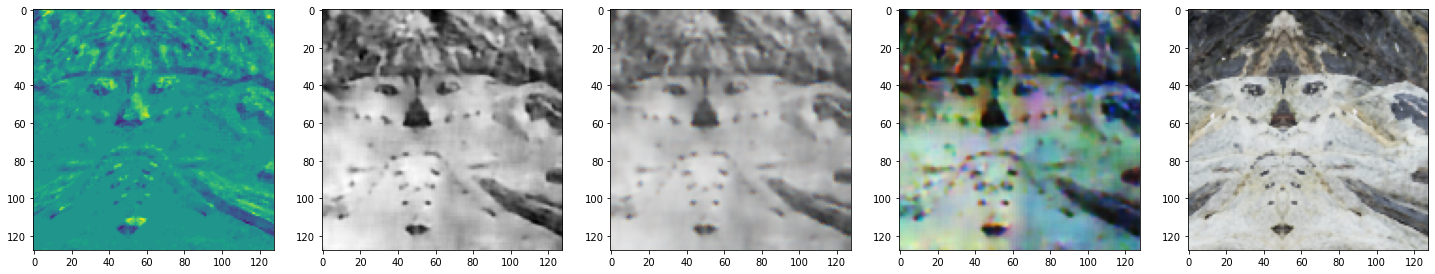

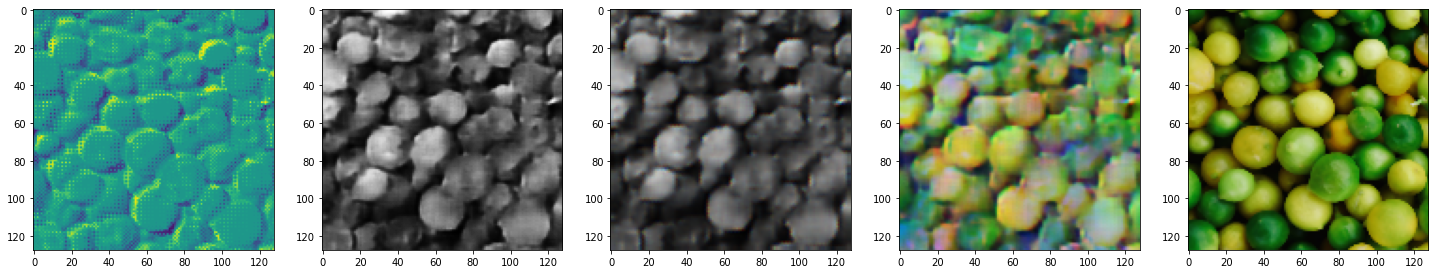

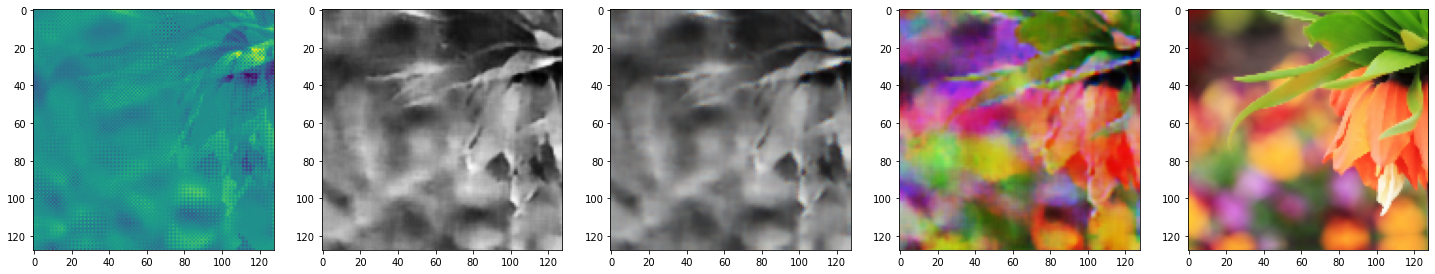

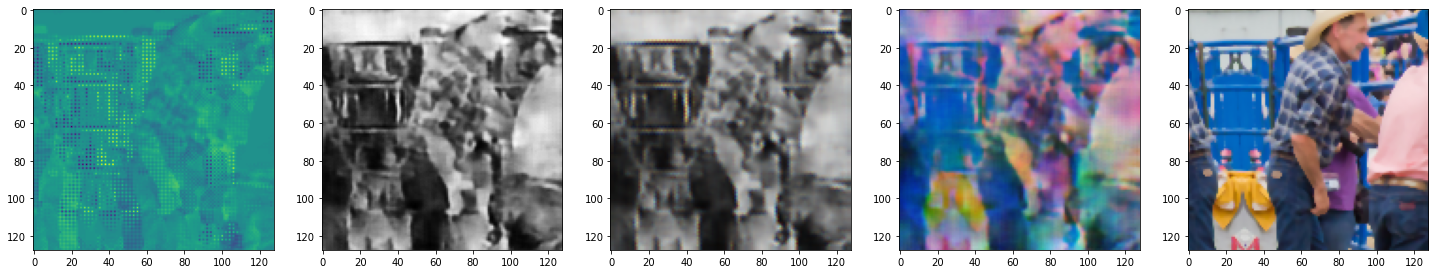

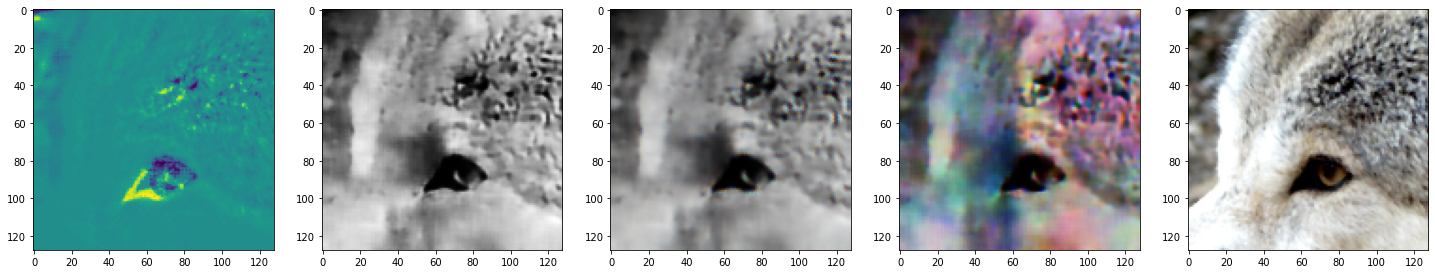

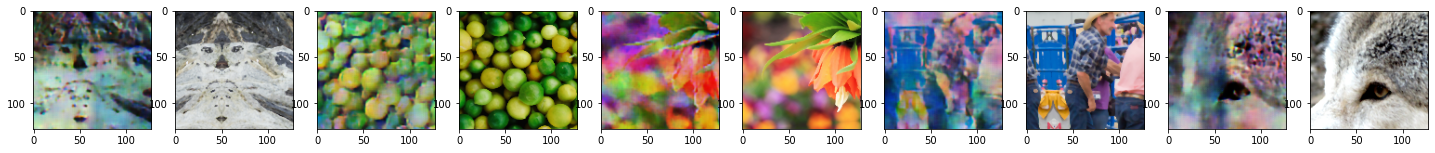

In [ ]:
from media_utils import denorm_img
out = model(valid_batch[0])[0].detach().cpu()
imgs = valid_batch[1]

def resolve_image(events: np.ndarray, model: torch.nn.Module):
    up = torch.nn.Upsample(scale_factor=(2, 2), mode="bilinear")
    r = events[:, 0::2, 0::2]
    g = (events[:, 0::2, 1::2] + events[:, 1::2, 0::2]) / 2
    b = events[:, 1::2, 1::2]
    x = torch.stack([r, g, b])
    x = up(x)
    y = model(x)[0]
    image = torch.einsum("chw -> hwc", y.squeeze())
    return image.detach().cpu()


outputs = []
ground_truths = []

for events, img, gt in zip(valid_batch[0], out, imgs):
    cols = 5
    size = 5
    fig, axs = plt.subplots(1, cols, figsize=(cols * size, size))
    axs[0].imshow(events.sum(axis=0))
    axs[1].imshow(img.squeeze(), cmap="gray")
    raw = denorm_img(img.numpy()).squeeze()
    demosaic = cv2.demosaicing(raw, cv2.COLOR_BAYER_RGGB2RGB) 
    upscaled = resolve_image(events, model)
    outputs.append(upscaled)
    ground_truths.append(gt)
    axs[2].imshow(demosaic)
    axs[3].imshow(upscaled)
    axs[-1].imshow(gt)
    plt.show()

fig, axs = plt.subplots(1, len(outputs) * 2, figsize=(5 * len(outputs), 5))
for i in range(len(outputs)):
    axs[i * 2].imshow(outputs[i])
    axs[i * 2 + 1].imshow(ground_truths[i])
plt.show()